## _*Quantum Teleportation and Superdense Coding*_ 


The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.


## Introduction

In this notebook, we will explore how the entangled states can be used in two quantum communication protocols:
* [Teleportation](#teleportation), where a qubit state is transmitted using two classical bits; and
* [Superdense Coding](#superdensecoding), where two classical bits are transmitted using one qubit. 

In [15]:
# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, IBMQ, execute
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# useful additional packages 
import numpy as np #library for scientific computing

## Quantum Teleportation <a id='teleportation'></a>

Quantum teleportation is a protocol to transmit quantum states from one location to another, assisted by a previously shared entangled state and a classical communication channel. It was devised by Charles H. Bennett (IBM), Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William K. Wootters in [1993](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895). It was first demonstrated with photons in [1997](http://www.nature.com/nature/journal/v390/n6660/abs/390575a0.html), and has since been realised in [atoms](http://www.nature.com/nphys/journal/v9/n7/abs/nphys2631.html), [ions](http://www.nature.com/nature/journal/v429/n6993/full/nature02570.html, http://www.nature.com/nature/journal/v429/n6993/full/nature02608.html), [electrons](http://science.sciencemag.org/content/345/6196/532) and [superconducting circuits](http://www.nature.com/nature/journal/v500/n7462/full/nature12422.html). The [record](http://www.nature.com/nature/journal/v489/n7415/full/nature11472.html) distance for quantum teleportation is 143 km via satellite, set in 2012.

<img src="images/teleportation.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">

As illustrated above, the protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

Alice has a quantum state that she wants to convey to Bob:
$$|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$$

At this point, Alice has two quantum states ($C$, the data qubit she wants to teleport, and $A$, one of the entangled pair), and Bob has one quantum state. The total state of the system is given by:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B) \otimes (\alpha|0_C\rangle + \beta|1_C\rangle)$$
or, in the Bell basis:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{2}[
|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) + \\
|\Psi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Psi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) ]$$
where:
$$|0\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle + |\Phi^-\rangle), 
|0\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle + |\Psi^-\rangle)\\
|1\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle - |\Psi^-\rangle), 
|1\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle - |\Phi^-\rangle).$$

Alice now measures her two quantum states, $A$ and $C$, in the Bell basis. This will collapse the three state system into the one of the following four states with equal probability, with the corresponding measurement outcomes:
- **00**: $|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$
- **01**: $|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$
- **10**: $|\Psi^+\rangle_{AC}\otimes(\alpha|1\rangle_B + \beta|0\rangle_B)$ 
- **11**: $|\Psi^-\rangle_{AC}\otimes(-\alpha|1\rangle_B + \beta|0\rangle_B)$

Alice now sends the results of her measurements to Bob. Using this information, he performs one of the following transformations on his quantum state to transform it to the desired state $\alpha|0\rangle_B + \beta|1\rangle_B$:
- If he receives **00**, he applies $I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$
- If he receives **01**, he applies $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$
- If he receives **10**, he applies $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ 
- If he receives **11**, he applies $XZ = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$ 

Transmission (teleportation) of $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ is thus achieved. 

First, we need to setup our registers and circuit. We need three qubits (i.e. three quantum registers) and three classical registers for measurement. Note that three 1-bit classical registers must be used instead of one 3-bit register. This is to avoid errors when doing classically-controlled gates (e.g. `c_if()`) later.

In [16]:
# Creating registers ('tq', 'tc0', 'tc1', 'tc2')
tq = QuantumRegister(3)
tc0 = ClassicalRegister(1)
tc1 = ClassicalRegister(1)
tc2 = ClassicalRegister(1)


# Setup the quantum circuit 'teleport'
teleport = QuantumCircuit(tq, tc0, tc1, tc2)

The steps to make the shared entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$ are:
1. Start with an initial state $|0_A 0_B\rangle$
2. Apply Hadamard gate $H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$ on $q_A$ 
3. Then a $CNOT = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{pmatrix}$ from $q_A$ to $q_B$

Let us use $q_A = q_1$, $q_B = q_2$ and apply the entanglement:

In [17]:
# Add gates for creating an entangled state
teleport.h(tq[1])
teleport.cx(tq[1], tq[2])
teleport.barrier()

Alice then prepares her quantum state to be teleported, $|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$. In this experiment, $\alpha = \cos(\frac{\theta}{2})$ and $\beta = \sin(\frac{\theta}{2})$. Let's use $\theta = \frac{\pi}{3}$ (or any other angle), but $\theta$ is arbitrary in general, of course (and can include a complex phase). This state can be created by applying a rotation around the y axis:
$R_y(\theta)$ on $q_C$

Let us use $q_C = q_0$. Now apply the single-qubit rotation:

In [18]:
# Add the single-qubit rotation with Ry gate
# hint 'Ry' is applied in a similar way as other gates above, .ry('angle','qubit0')
theta_y = np.pi/3;
psi_c = np.array([np.cos(theta_y/2),np.sin(theta_y/2)])
psi_c2 = np.array([np.cos(theta_y/2)**2,np.sin(theta_y/2)**2])
teleport.ry(theta_y, tq[0])
teleport.barrier()
psi_c
psi_c2

array([0.75, 0.25])

Alice now applies $CNOT$ to her two quantum states, followed by an $H$, to entangle them and project them into the Bell basis.

Apply these gates on $q_A(q_1)$ and $q_C(q_0)$:

In [19]:
# Add the second entanglement gate
teleport.cx(tq[0], tq[1])
teleport.h(tq[0])
teleport.barrier()

Next, Alice measures her two quantum states $q_A(q_1)$ and $q_C(q_0)$. Let's measure the qubit into the same-indexed quantum register $q_i \to c_i$:

In [20]:
# Measure the states of qubits q_a and q_c into the appropriate classical registers
teleport.measure(tq[0], tc0)
teleport.measure(tq[1], tc1)
teleport.barrier()

Depending on the results of these measurements, Bob has to apply an $X$ or $Z$, or both, to his quantum state $q_B(q_2)$. This uses special syntax to control the quantum gate: `.c_if()`. For the $Z$ gate, we use `teleport.z(tq[2]).c_if(tc0, 1)`, where `tc0` is compared to `1`. What is the syntax for the $X$ gate?

In [21]:
# Apply the controlled gates with conditions.
teleport.z(tq[2]).c_if(tc0, 1)
teleport.x(tq[2]).c_if(tc1, 1)

Now let's measure Bob's resulting qubit to make sure we have successful teleportation!:

In [22]:
# Measure the remaining qubit into the remaining classical register
teleport.measure(tq[2], tc2)

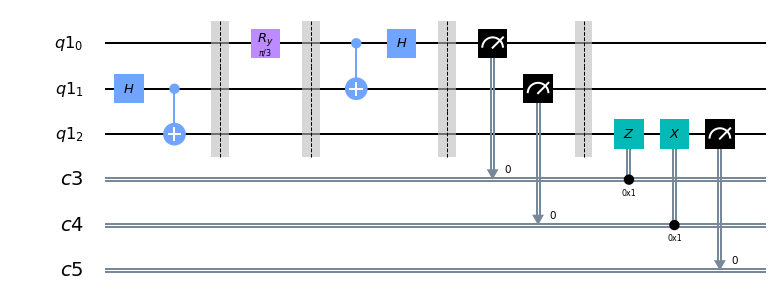

In [23]:
# Draw the circuit to make sure everything is sane
teleport.draw(output='mpl')

Let's now create and execute the quantum circuits and plot the results:

In [24]:
# Local simulations
local_backend = BasicAer.get_backend('qasm_simulator') 
# note that this circuit can not be run on an IBM Q device. Due to the restrictions that measurements should be always in the end of the circuit

# Job and result
teleport_job = execute(teleport, local_backend)
teleport_result = teleport_job.result()
job_monitor(teleport_job)

Job Status: job has successfully run


We must manipulate the data to understand the results better, first only plotting the results of Alice's measurement and ignoring Bob's results (note each classical register is seperated by a space, and the order is c2 c1 c0; this is very annoying). We've filled in the first data point; what are the other three?:

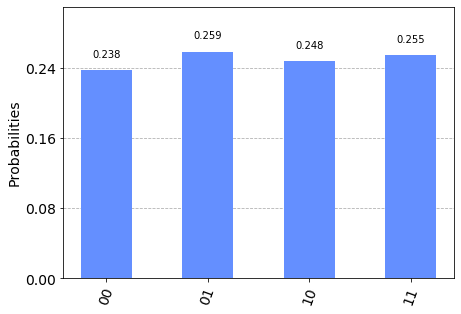

In [25]:
# Sort Alice's data from Bob's
data = teleport_result.get_counts(teleport)
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

The probabilities should be roughly equal.  

Now, manipulate the data to plot the result of Bob's measurement:

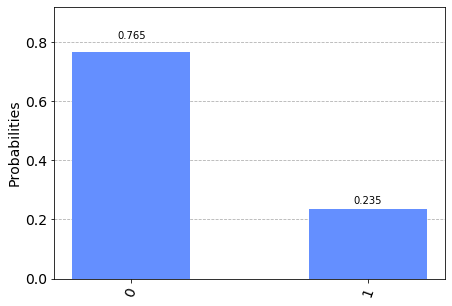

In [26]:
# Sort Bob's data from Alice's
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)

In [27]:
print(psi_c2)
psi_c2_calc = np.array([bob['0']/(bob['0']+bob['1']),bob['1']/(bob['0']+bob['1'])])
delta = abs((psi_c2-psi_c2_calc))
print(psi_c2_calc)
print(delta)
# np.abs(psi_c2_sim-psi_c2)

[0.75 0.25]
[0.76464844 0.23535156]
[0.01464844 0.01464844]


We expect $|\alpha|^2 = |\cos(\frac{\pi}{6})|^2 \approx 0.75$ (the probability of measuring 0) and $|\beta|^2 = |\sin(\frac{\pi}{6})|^2 \approx 0.25$ (the probability of measuring 1). Why don't you try teleporting a different quantum state now?

### Extended Thoughts

Why are three qubits used instead of two? Couldn't we have just let Bob have $q_A$, ignored $q_B$, and only do one step of entanglement (i.e. only one bell-state measurement, rather than two)? The answer is yes, two qubits are sufficient for teleportation. However, creating long-distance entanglement is very difficult. If Alice and Bob are very far away from each other, it is sometimes better from the standpoint of system robustness to first prepare the two-qubit state (which might be probabilistic and hard) and do the (easier) local bell state measurment between Alice's control qubit afterward. Also, some systems do not permit two-qubit teleportation. For instance, The 2012 satellite quantum teleportation result would not work with two, as an entangled bell-pair of photons was sent down from the sattelite, one of which is measured in the bell basis with the data qubit at Alice's node.

## Quantum Superdense Coding<a id='superdensecoding'></a>

Quantum superdense coding is the dual protocol of quantum teleportation, whereby two classical bits of information are transmitted using only one qubit and a previously shared entangled state. It was devised by Charles Bennett (IBM) and Stephen Wiesner in [1992](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.69.2881). 

<img src="images/superdensecoding.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">

As illustrated above, and as in quantum teleportation, the protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

Alice wants to send a two bit message to Bob, 00, 01, 10, or 11.  She performs a single qubit operation on her qubit which transforms the entangled state according to which message she wants to send:
- For a message of **00**: Alice applies $I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$. The resultant state would be $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$
- For a message of **01**: Alice applies $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$. The resultant state would be $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$  
- For a message of **10**: Alice applies $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$. The resultant state would be $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$ 
- For a message of **11**: Alice applies $XZ = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$. The resultant state would be $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle)$

The key to superdense coding is that these four states, $|\psi_{00}\rangle, |\psi_{01}\rangle, |\psi_{10}\rangle, |\psi_{11}\rangle$ (also known as the [Bell states](https://en.wikipedia.org/wiki/Bell_state)), are orthonormal and are hence distinguishable by a quantum measurement.

First, we want to create all of the registers. Recall that this is a two qubit algorithm:

In [28]:
# Create two quantum registers 'sdq' and two classical ones 'sdc'
sdq = QuantumRegister(2)
sdc = ClassicalRegister(2)

Now, let's make ourselves a circuit and an entangled bell state:

In [29]:
# Make the quantum circuit 'superdense'
superdense = QuantumCircuit(sdq, sdc)

In [30]:
# Make the shared entangled state 
superdense.h(sdq[0])
superdense.cx(sdq[0], sdq[1])
superdense.barrier()

Alice now needs to decide what two bit message she wants to transmit to Bob, ($00$, $01$, $10$, or $11$), and perform the corresponding to transformation ($I$, $X$, $Z$ or $XZ$ respectively) to her qubit $q_A$ ($q_0$). What would the gates be in each case? Leave all but one case uncommented:

In [31]:
# For 00, do nothing

# For 01, apply $X$
# superdense.x(sdq[0])

# For 01, apply $Z$
#superdense.z(sdq[0])

# For 11, apply $XZ$
superdense.z(sdq[0]) 
superdense.x(sdq[0])

superdense.barrier()

Bob now needs to 'decode' the message that Alice sent him. Since measurement in Qiskit is only possible in the standard computational basis, he does this by:
1. Applying a $CNOT$ from $q_A$ to $q_B$
2. Then a $H$ on $q_A$ 
3. And measuring $q_A$ and $q_B$

It's essentially the same process as creating the state, except backwards:

In [32]:
# Do the gates
superdense.cx(sdq[0], sdq[1])
superdense.h(sdq[0])

superdense.barrier()

# Measure the qubits
superdense.measure(sdq[0], sdc[0])
superdense.measure(sdq[1], sdc[1])

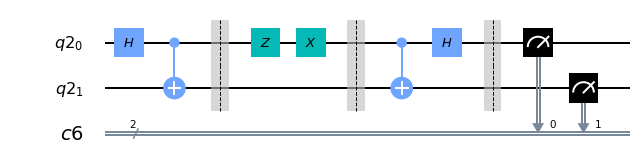

In [38]:
# Draw the circuit for sanity
superdense.draw(output='mpl')

Let's now create and execute the quantum circuits, and then plot the results:

In [39]:
backend = BasicAer.get_backend('qasm_simulator') # run on local simulator by default 

# Uncomment the following lines to run on a real device
# from qiskit import IBMQ
# from qiskit.providers.ibmq import least_busy

# # Load local account information
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q')
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))
# print("least busy backend: ", backend)

In [41]:
# shots = 256
# superdense_job = execute(superdense, backend=backend, shots=shots)
superdense_job = execute(superdense, backend = backend)
job_monitor(superdense_job)

Job Status: job has successfully run


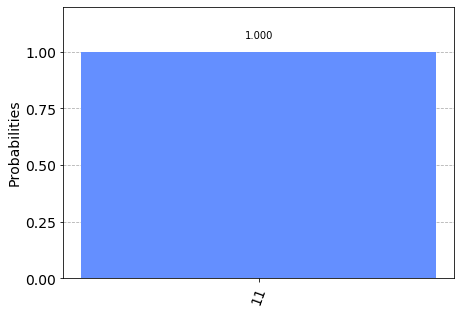

In [42]:
superdense_results = superdense_job.result()
plot_histogram(superdense_results.get_counts(superdense))

The state with the highest probability should match the message that Alice encoded! Try all of the cases! 
Mathematically:
- For a message of **00**: 
    - Bob received $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 0_B\rangle)$.
    - Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle + (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |0_A 0_B\rangle$ 
- For a message of **01**: 
    - Bob received $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle)+ |1_A 1_B\rangle$. 
    - Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle + (|0_A\rangle - |1_A\rangle)|1_B\rangle ] = |0_A 1_B\rangle$ 
- For a message of **10**: 
    - Bob received $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 0_B\rangle)$. 
    - Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle - (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |1_A 0_B\rangle$ 
- For a message of **11**: 
     - Bob received $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle - |1_A 1_B\rangle)$. 
     - Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle - (|0_A\rangle - |1_A\rangle)|1_B\rangle] = |1_A 1_B\rangle$ 

### Extended Thoughts

We're proportedly sending two classical bits through a single quantum bit ... using two quantum bits? Wait, this doesn't seem dense (let alone superdense) at all. Actually, one can imagine that Alice is very far away from Bob, and she applies (or doesn't apply) her gates very far away from all of the other gates. That is, only one qubit is neccessarily sent to Alice and back even though two are in the system (Bob's qubit stays home). This superdense encoding has interesting security applications. If Eve is evesedropping on Alice's qubit as it shuttles back and forth, Eve cannot possibly know all the data that Alice sent because Eve can at most measure a single qubit.